### Importing Libraries

In [ ]:
!pip install arch

     |████████████████████████████████| 899 kB 4.0 MB/s 
     |████████████████████████████████| 9.8 MB 38.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 3.4 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import iqr
from scipy.stats import kurtosis
from scipy.stats import skew
from statsmodels.tsa.stattools import adfuller
import arch.unitroot as at
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from pmdarima.arima import auto_arima
from scipy.stats import boxcox
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.special import inv_boxcox

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading the data

The data can be downloaded from https://www.kaggle.com/dougcresswell/daily-total-female-births-in-california-1959


Data description : A time series dataset depicting the total number of female births recording in California, USA during the year of 1959. This is a very basic time series dataset with only the date ("dd/mm/yyyy" format) and the number of births.There are 365 records in total.

In [ ]:
# Loading the data

data = pd.read_csv("/content/drive/MyDrive/Datasets/daily-total-female-births-CA.csv",header = 0,parse_dates=[0])
data.columns = ['Date','Value']
data['Date'] = pd.to_datetime(data['Date'],infer_datetime_format=True)
data.dropna(inplace=True)
data.head()

,Date,Value
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


### Data Preprocessing

Data ordering

In [ ]:
# Finding out the start and end date to ensure the data is ordered

data['Date'].min(), data['Date'].max()

(Timestamp('1959-01-01 00:00:00'), Timestamp('1959-12-31 00:00:00'))

In [ ]:
# Applying chronological ordering to the data based on the dates

data = data.sort_values('Date')
data

,Date,Value
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44
...,...,...
360,1959-12-27,37
361,1959-12-28,52
362,1959-12-29,48
363,1959-12-30,55


In [ ]:
# Getting the descriptive statistics of the entire data

data.describe()

,Value
count,365.000000
mean,41.980822
std,7.348257
min,23.000000
25%,37.000000
50%,42.000000
75%,46.000000
max,73.000000


In [ ]:
kurt = kurtosis(data.Value)
skw = skew(data.Value)
print("Skewness: {}".format(round(skw,3)))
print("Kurtosis: {}".format(round(kurt,3)))

Skewness: 0.446
Kurtosis: 0.751


Data Visualization

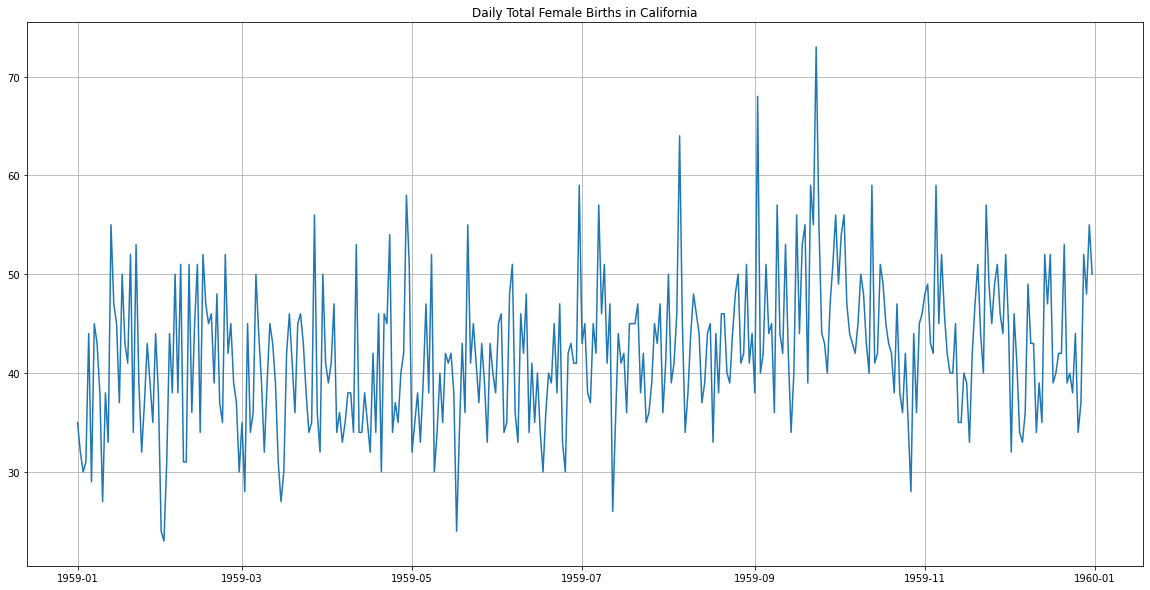

In [ ]:
# Visualizing the time series data

plt.figure(figsize=(20,10))
plt.plot(data['Date'], data['Value']);
plt.grid()
plt.title('Daily Total Female Births in California')
plt.show()

Missing values

In [ ]:
# Checking for null values

data.isnull().sum()

Date     0
Value    0
dtype: int64

In [ ]:
# No null values present
# Hence, we do not need to drop any row or column or impute values.

Train-test Split

In [ ]:
# Split to train and test data
# Considering 300 data points for training and 65 for forecasting

train = data[:300]
test = data[300:]

In [ ]:
train.head()

,Date,Value
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


In [ ]:
test.head()

,Date,Value
300,1959-10-28,44
301,1959-10-29,36
302,1959-10-30,45
303,1959-10-31,46
304,1959-11-01,48


In [ ]:
# Keeping copies of data for plotting purposes

train_copy = train.copy()
test_copy = test.copy()

Descriptive Statistics

In [ ]:
# Calculating descriptive statistics of train data

descriptive_stats = train.describe()
print(descriptive_stats)

            Value
count  300.000000
mean    41.626667
std      7.509679
min     23.000000
25%     36.000000
50%     41.000000
75%     46.000000
max     73.000000


In [ ]:
kurt = kurtosis(train.Value)
skw = skew(train.Value)
print("Skewness: {}".format(round(skw,3)))
print("Kurtosis: {}".format(round(kurt,3)))

Skewness: 0.527
Kurtosis: 0.95


In [ ]:
std = round(float(descriptive_stats.loc['std']),3)
mean = round(float(descriptive_stats.loc['mean']),3)

Outliers

In [ ]:
# Calculatig the percentage of data in the 3-sigma range to detect outliers

std_lower = mean - (3 * std)
std_upper = mean + (3 * std)
count = 0
for i in range(len(train)):
  if train.Value[i] < std_lower and train.Value[i] > std_upper:
    count = count + 1
perc = ((len(train) - 0)/len(train))*100
print("The percentage of data lying in the range (mu - 3*sigma, mu + 3*sigma) is {}%".format(perc))

The percentage of data lying in the range (mu - 3*sigma, mu + 3*sigma) is 100.0%


In [ ]:
# Hence, the data is free of outliers

Train Data Visualization

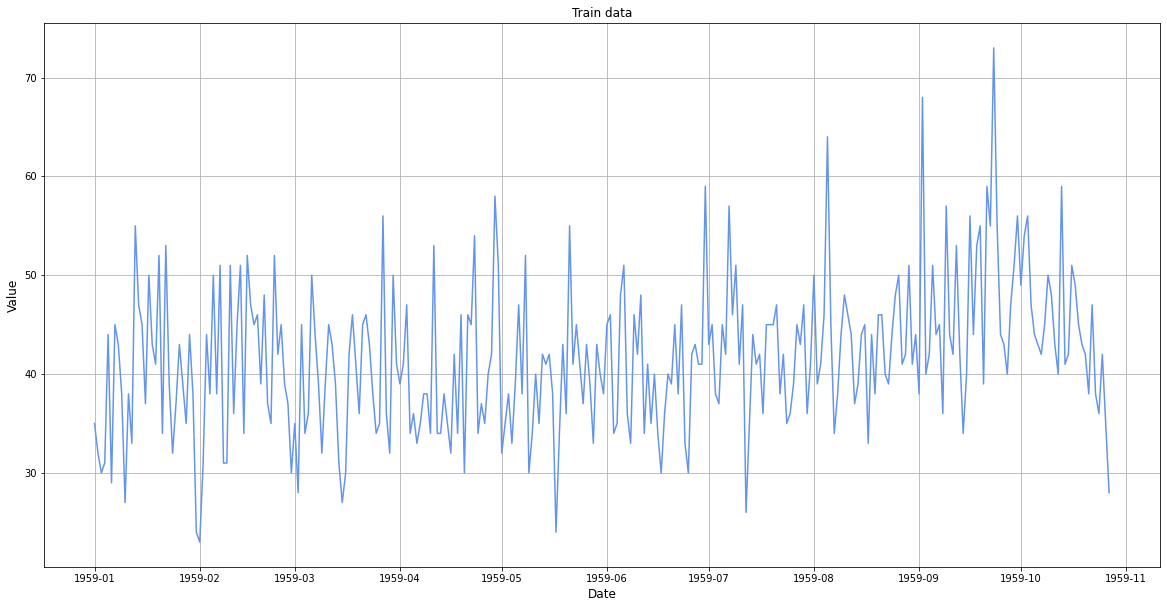

In [ ]:
# Plot of the train data

plt.figure(figsize = (20,10))
plt.plot(train['Date'],train['Value'], color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Value', size = 12)
plt.grid()
plt.title('Train data')
plt.show()

### Tests for stationarity

Augmented Dickey Fuller (ADF) Test

Null Hypothesis: The time series has a unit root and hence not stationary \\
Alternative Hypothesis : The time series is stationary.

In [ ]:
def ADF_test(ts):
    
    adf = adfuller(ts, autolag='AIC')
    print("===Augmented Dickey Fuller test===")
    print()
    print('ADF Statistic: {}'.format(round(adf[0],3)))
    print('p-value: {}'.format(round(adf[1],3)))
    print()  
    print('Critical Values:')
    
    for key, ts in adf[4].items():
         print('{}: {}'.format(key, round(ts,3)))
    print()
    
    if adf[0] > adf[4]["5%"] and adf[1] > 0.05:
        print("ADF > Critical Values")
        print ("Failed to reject null hypothesis")
        print("The time series is non-stationary.")
    else:
        print("ADF < Critical Values")
        print ("Null hypothesis is rejected")
        print("The time series is stationary")
        

In [ ]:
ADF_test(train.Value)

===Augmented Dickey Fuller test===

ADF Statistic: -3.546
p-value: 0.007

Critical Values:
1%: -3.453
5%: -2.871
10%: -2.572

ADF < Critical Values
Null hypothesis is rejected
The time series is stationary


Phillips Perron (PP) Test

Null Hypothesis: The time series has a unit root and hence not stationary \\
Alternative Hypothesis : The time series is stationary.

In [ ]:
def PP_test(ts):
    
    pp = at.PhillipsPerron(ts, trend = 'ct', test_type = 'tau')
    print("===Phillips Perron test===")
    print()
    p = pp.pvalue
    print('PP Statistic: {}'.format(np.round(pp.stat,3)))
    print('p-value: {}'.format(np.round(pp.pvalue,3)))
    print()
    print('Critical Values:')
    for key, value in pp.critical_values.items():
      print('{}: {}'.format(key, round(value,3)))
    print()
    pp_statistic = np.round(pp.stat,3)
    critical_v = pp.critical_values['5%']
    if pp_statistic > critical_v and p > 0.05:
        print("PP > Critical Values")
        print ("Failed to reject null hypothesis")
        print("The time series is non-stationary.")
    else:
        print("PP < Critical Values")
        print ("Null hypothesis is rejected")
        print("The time series is stationary")
        

In [ ]:
PP_test(train.Value)

===Phillips Perron test===

PP Statistic: -15.552
p-value: 0.0

Critical Values:
1%: -3.989
5%: -3.425
10%: -3.136

PP < Critical Values
Null hypothesis is rejected
The time series is stationary


In [ ]:
def KPSS_test(ts):
    
    kpss = at.KPSS(ts, trend = 'ct')
    print("===KPSS test===")
    print()
    print('KPSS Statistic: {}'.format(np.round(kpss.stat,3)))
    p_value = np.round(kpss.pvalue,3)
    print('p-value: {}'.format(np.round(kpss.pvalue,3)))
    print()
    print('Critical Values:')
    for key, value in kpss.critical_values.items():
      print('{}: {}'.format(key, round(value,3)))
    print()
    kpss_statistic = np.round(kpss.stat,3)
    critical_v = kpss.critical_values['5%']
    if kpss_statistic < critical_v:
        print("KPSS < Critical Values")
        print ("Failed to reject Null hypothesis")
        print("The time series is stationary.")
    else:
        print("KPSS > Critical Values")
        print ("Null hypothesis is rejected")
        print("The time series is non-stationary")
        

In [ ]:
KPSS_test(train.Value)

===KPSS test===

KPSS Statistic: 0.169
p-value: 0.031

Critical Values:
1%: 0.218
5%: 0.148
10%: 0.119

KPSS > Critical Values
Null hypothesis is rejected
The time series is non-stationary


Conclusion : Here, we observe that for ADF and PP test, we get the data to be stationary but not for KPSS test. Hence, we transform the data to logarithmic scale and further test for stationarity.

In [ ]:
train_copy = train_copy.set_index(['Date'])
test_copy = test_copy.set_index(['Date'])

In [ ]:
train_copy.head()

,Value
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [ ]:
test_copy.head()

,Value
Date,
1959-10-28,44
1959-10-29,36
1959-10-30,45
1959-10-31,46
1959-11-01,48


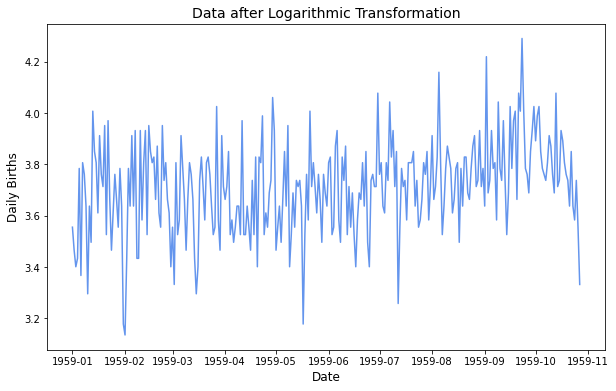

In [ ]:
# log scaling the data

df_log_scaled = train_copy
df_log_scaled['Value'] = boxcox(df_log_scaled['Value'], lmbda=0.0)
plt.figure(figsize = (10,6))
plt.plot(df_log_scaled, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Daily Births', size = 12)
plt.title("Data after Logarithmic Transformation", size = 14)
plt.show()

In [ ]:
# Scaling the test data for evaluation purposes
test_log_scaled = test_copy
test_log_scaled['Value'] = boxcox(test_log_scaled['Value'], lmbda=0.0)

In [ ]:
train_new = df_log_scaled[:]
test_new = test_log_scaled[:]

In [ ]:
train_new.head()

,Value
Date,
1959-01-01,3.555348
1959-01-02,3.465736
1959-01-03,3.401197
1959-01-04,3.433987
1959-01-05,3.784190


In [ ]:
test_new.head()

,Value
Date,
1959-10-28,3.784190
1959-10-29,3.583519
1959-10-30,3.806662
1959-10-31,3.828641
1959-11-01,3.871201


In [ ]:
# Testing for stationarity after log scale transformation

KPSS_test(df_log_scaled)

===KPSS test===

KPSS Statistic: 0.142
p-value: 0.058

Critical Values:
1%: 0.218
5%: 0.148
10%: 0.119

KPSS < Critical Values
Failed to reject Null hypothesis
The time series is stationary.


In [ ]:
PP_test(df_log_scaled)

===Phillips Perron test===

PP Statistic: -14.984
p-value: 0.0

Critical Values:
1%: -3.989
5%: -3.425
10%: -3.136

PP < Critical Values
Null hypothesis is rejected
The time series is stationary


In [ ]:
ADF_test(df_log_scaled)

===Augmented Dickey Fuller test===

ADF Statistic: -3.59
p-value: 0.006

Critical Values:
1%: -3.453
5%: -2.871
10%: -2.572

ADF < Critical Values
Null hypothesis is rejected
The time series is stationary


Conclusion: The transformed data is stationary.

Therefore, we will use the transformed data for training purposes

### Fitting the Model

In [ ]:
# Searching for appropriate parameters based on AIC

arima_model =  auto_arima(train_new,start_p=0, start_q=0,d=1,
                          test = 'adf',trace = True)
#Summary of the model
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-43.681, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-107.554, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-194.026, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-45.677, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-194.713, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-196.991, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-109.551, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-195.058, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-195.040, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-196.780, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-132.372, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-193.024

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  300
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 101.495
Date:                Thu, 04 Nov 2021   AIC                           -196.991
Time:                        04:14:15   BIC                           -185.890
Sample:                             0   HQIC                          -192.548
                                - 300                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1274      0.061      2.086      0.037       0.008       0.247
ma.L1         -0.9617      0.021    -45.960      0.000      -1.003      -0.921
sigma2         0.0295      0.002     12.958      0.000       0.025       0.034
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.86
Prob(Q):                              0.85   Prob(JB):                         0.65
Heteroskedasticity (H):               0.67   Skew:                             0.04
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Fitting the 1,1,1 ARIMA Model because it gives the least AIC

model = ARIMA(train_new['Value'], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  300
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 101.495
Date:                Thu, 04 Nov 2021   AIC                           -196.991
Time:                        04:14:15   BIC                           -185.890
Sample:                    01-01-1959   HQIC                          -192.548
                         - 10-27-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1274      0.061      2.086      0.037       0.008       0.247
ma.L1         -0.9617      0.021    -45.960      0.000      -1.003      -0.921
sigma2         0.0295      0.002     12.958      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [ ]:
# Obtaining plots for residuals
residuals = pd.DataFrame(model_fit.resid)

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

### Forecasting

In [ ]:
history = [x for x in train_new.Value]
predictions = list()


In [ ]:
# Obtaining forecasts and calculating the test MSE

for t in range(len(test_new)):
  model = ARIMA(history, order = (1,1,1))
  model_fit = model.fit()
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  obs = test_new.Value.iloc[t]
  history.append(obs)
rmse = sqrt(mean_squared_error(test_new.Value, predictions))
print("Test RMSE: %.3f" % rmse)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Test RMSE: 0.144


In [ ]:
# Performing reverse transformation on the log-scale data, to obtain the original value of the predictions

preds = inv_boxcox(predictions, 0.0)

In [ ]:
test_1 = test.Value.reset_index(drop = True)

In [ ]:
# Printing predictions
print("===FORECASTS===")
print()
for i in range(len(preds)):
  print("Predicted: {}, Expected: {}".format(round(preds[i]),test_1[i]))

===FORECASTS===

Predicted: 41, Expected: 44
Predicted: 44, Expected: 36
Predicted: 42, Expected: 45
Predicted: 44, Expected: 46
Predicted: 44, Expected: 48
Predicted: 44, Expected: 49
Predicted: 45, Expected: 43
Predicted: 44, Expected: 42
Predicted: 44, Expected: 59
Predicted: 46, Expected: 45
Predicted: 44, Expected: 52
Predicted: 46, Expected: 46
Predicted: 45, Expected: 42
Predicted: 44, Expected: 40
Predicted: 44, Expected: 40
Predicted: 44, Expected: 45
Predicted: 44, Expected: 35
Predicted: 43, Expected: 35
Predicted: 42, Expected: 40
Predicted: 43, Expected: 39
Predicted: 43, Expected: 33
Predicted: 41, Expected: 42
Predicted: 43, Expected: 47
Predicted: 43, Expected: 51
Predicted: 44, Expected: 44
Predicted: 43, Expected: 40
Predicted: 43, Expected: 57
Predicted: 45, Expected: 49
Predicted: 44, Expected: 45
Predicted: 44, Expected: 49
Predicted: 45, Expected: 51
Predicted: 45, Expected: 46
Predicted: 45, Expected: 44
Predicted: 44, Expected: 52
Predicted: 46, Expected: 45
Pre

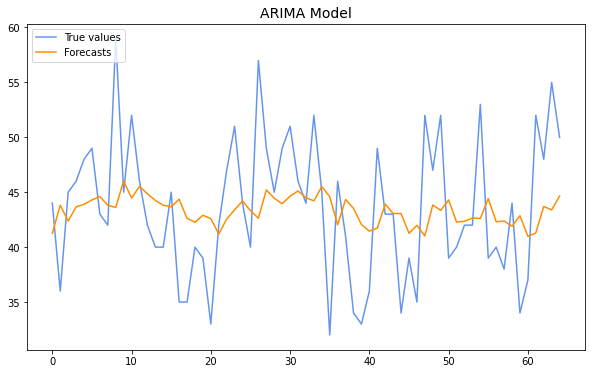

In [ ]:
# Plotting the model for visualization

plt.figure(figsize = (10,6))
plt.plot(test_1, label = "True values", color = "cornflowerblue")
plt.plot(preds,label = "Forecasts", color='darkorange')
plt.title("ARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()